# Society of Mind

In [1]:
import torch
import numpy as np
import numpy.random as rd
import time
import argparse
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import functools

import matplotlib.pyplot as plt
from scipy.optimize import fsolve

from torchvision import datasets, transforms

import copy
from torch.optim.lr_scheduler import StepLR

from tqdm import tqdm
#from tqdm.notebook import tqdm, trange

from torchviz import make_dot

import os, sys

In [2]:
sys.path.append('../')
from dual_models import *
from common.models import *
from common.decision import *
from common.training import *
from common.utils_diverse import *
from dual_utils import *

In [3]:
import warnings
#warnings.filterwarnings('ignore')

In [4]:
%load_ext autoreload
%autoreload 2
%aimport -dual_models


In [5]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 256
train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': 256}
if use_cuda:
    cuda_kwargs = {'num_workers': 0,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

dataset1 = datasets.MNIST('/home/gb21/Code/ANNs/Data/MNIST', train=True, download=False,
                   transform=transform)
dataset2 = datasets.MNIST('/home/gb21/Code/ANNs/Data/MNIST', train=False,
                   transform=transform)

double_dataset1 = DoubleMNIST(asym=False)
double_dataset2 = DoubleMNIST(train=False, asym=False)

train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)
train_loader.n_classes, test_loader.n_classes = 10, 10

double_train_loader = torch.utils.data.DataLoader(double_dataset1,**train_kwargs)
double_test_loader = torch.utils.data.DataLoader(double_dataset2, **test_kwargs)
double_train_loader.single_loader, double_test_loader.single_loader = train_loader, test_loader
double_train_loader.n_classes, double_test_loader.n_classes = 100, 100


sub_train_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(dataset1, np.arange(batch_size)),**train_kwargs)
sub_test_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(dataset2, np.arange(batch_size)),**train_kwargs)

dtype = torch.float32


## Conv Community : 

In [6]:
#loaders = double_train_loader, double_test_loader
loaders = train_loader, test_loader
data, target = next(iter(loaders[0]))
data = temporal_data(data, flatten=False).to(device)

n_hid = 25

p_global = 0.2
p_connect = p_global/2
#p_connect = 10*1/n_hid**2
n_out = 10
n_out_sup = 90
n_agents = 8

community = ConvCommunity(data[0][0].shape, Nhid=[4, n_agents], kernel_size=[7, 5, 3], num_conv_layers=2, 
                          n_hid=n_hid, n_out=n_out, p_connect=p_connect, pool_size = [2, 2, 1],
                          decouple=False, distance_based_sparsity=False, cell_type=nn.GRU,
                          use_deciding_agent=False, use_sparse_readout=False,
                          ).to(device)


In [7]:
params = lr, gamma = 1e-3, 0.9
params_dict = {'lr' : lr, 'gamma' : gamma}

deepR_params = l1, gdnoise, lr, gamma, cooling = 1e-5, 1e-3, 1e-3, 0.95, 0.95
deepR_params_dict = {'l1' : l1, 'gdnoise' : gdnoise, 'lr' : lr, 'gamma' : gamma, 'cooling' : cooling}

optimizers, schedulers = init_optimizers(community, params_dict, deepR_params_dict)

In [8]:
n

NameError: name 'n' is not defined

In [ ]:
n_epochs = 1
decision_params = ('last', 'max')
task='none'

train_out = train_community(community, device, *loaders, optimizers, 
                            schedulers=schedulers, n_epochs=n_epochs, global_rewire=True, 
                            task=task, decision_params=decision_params, data_mode='fixed',
                            deepR_params_dict=deepR_params_dict, trials = (True, True))
                            
(train_losses, train_accs), (test_losses, test_accs), deciding_agents, nb_reconnect, nb_connections, best_state = train_out

  0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
plt.figure(1, figsize=(10, 5))
get_connects = lambda tag : [con[tag] for con in nb_connections]
for n1 in range(community.n_agents) : 
    for n2 in range(community.n_agents) :
        if n1 != n2 : 
            plt.plot(get_connects(str(n1) + str(n2)), label = f'{n1} -> {n2} active connections')
            
#plt.plot(get_connects('readout'), label = 'Readout active connections', linestyle='--')
for ag in community.agents : 
    #plt.plot(get_connects('conv-'+ag.tag), label = f'Agent {ag.tag} Read-in active connections', linestyle='--')
    ''
plt.legend()

NameError: name 'nb_connections' is not defined

<Figure size 720x360 with 0 Axes>

In [ ]:
plt.plot(torch.mean(torch.stack(deciding_agents).float(), axis=-1).cpu())
plt.title(f'Mean = {torch.mean(torch.stack(deciding_agents).float())}')
plt.show()

## SupSup Community    

### Init

In [9]:
#loaders = double_train_loader, double_test_loader
loaders = train_loader, test_loader

data, target = next(iter(loaders[0]))
data = temporal_data(data, flatten=False).to(device)

n_hid = 25

p_global = 0.2
p_connect = p_global/2
#p_connect = 10*1/n_hid**2
n_out = 10
n_out_sup = 90
n_agents = 8
#mask_samples = batch_size // 8
mask_samples = 0

community = SupSupCommunity(data[0][0].shape, Nhid=[4, n_agents], kernel_size=[7, 5, 3], num_conv_layers=2, 
                          n_hid=n_hid, n_out=n_out, p_connect=p_connect, pool_size = [2, 2, 1], n_out_sup=n_out_sup,
                          decouple=False, distance_based_sparsity=False, cell_type=nn.GRU,
                          use_deciding_agent=False, use_sparse_readout=False, temporal_masks=False,
                          mask_samples=mask_samples).to(device)

#community(data, 'skip');

In [10]:
params = lr, gamma = 1e-4, 0.95
params_dict = {'lr' : lr, 'gamma' : gamma}

deepR_params = l1, gdnoise, lr, gamma, cooling = 1e-5, 1e-5, 1e-3, 0.95, 0.99
deepR_params_dict = {'l1' : l1, 'gdnoise' : gdnoise, 'lr' : lr, 'gamma' : gamma, 'cooling' : cooling}

optimizers, schedulers = init_optimizers(community, params_dict, deepR_params_dict)

### Training

In [11]:
decision_params = ('last', 'sum') 
mask_params_dict = {'lr' : 5e-1, 'gamma' : 0.9}

global_task = 'none'
continual_task, n_tasks = 'sequential', 10
#continual_task, n_tasks = 'none', 0

n_epochs = n_tasks//5

continual_settings = {'task' : continual_task, 'n_tasks' : n_tasks, 'infer_task' : (False, False),
                      'sequential' : True, 'pretrain' : False, 'change_mode' : 'acc', 'fix_learning' : False}
#continual_settings = {}
    
train_out = train_community(community, device, *loaders, optimizers, 
                            schedulers=schedulers, n_epochs=n_epochs, global_rewire=True,
                            task=global_task, decision_params=decision_params, data_mode='fixed', check_gradients=False,
                            params_dict = params_dict, deepR_params_dict=deepR_params_dict, masks_params_dict=mask_params_dict,
                            trials = (True, True), train_connections=True, reg_loss=False, continual_settings=continual_settings)

        
(train_losses, train_accs), (test_losses, test_accs), deciding_agents, nb_reconnect, nb_connections, best_state, (nb_examples_tasks, first_epoch, first_masks) = train_out
#torch.save(best_state, 'SupSupCommunity_5ag_100perms')

  0%|          | 0/2 [00:00<?, ?it/s]

------Finished------


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


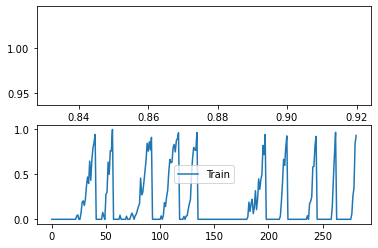

In [12]:
fig, axs = plt.subplots(2, 1)
plot_running_data(test_accs, axs[0], m=1, label='Test')
plot_running_data(train_accs, axs[1], m=1, label='Train')


In [ ]:
#sup_sup_load_dict(community, 'SupSupCommunity_5ag_100perms', data)

In [13]:
continual_settings_test = {'task' : continual_task, 'n_tasks' : n_tasks, 'infer_task' : (False, False)}
test_out = test_community(community, device, loaders[1],
                            decision_params, task=global_task,
                            continual_settings=continual_settings_test)

desc, test_loss, acc, acc_per_seed = test_out
np.array(list(acc_per_seed.values())).mean(), acc_per_seed

RuntimeError: CUDA error: invalid configuration argument
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

### Task Performance Grid

In [ ]:
acc_totals = {}
for task in tqdm(sorted(community.task_ints)) :
    task_id = str(task)
    continual_settings_test = {'task' : continual_task, 'n_tasks' : n_tasks, 'infer_task' : (False, True), 'imposed_mask' : task_id}
    test_out = test_community(community, device, loaders[1],
                                decision_params, task=global_task,
                                continual_settings=continual_settings_test)

    desc, test_loss, acc, acc_per_seed = test_out
    acc_per_seed = {key : acc_per_seed[key] for key in sorted(acc_per_seed.keys(), key=lambda s : int(s))}
    acc_totals[task_id] = acc_per_seed

  0%|          | 0/4 [00:00<?, ?it/s]

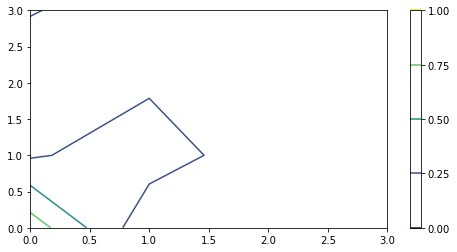

In [ ]:
acc_totals_np = np.array([np.array(list(acc_per_seed.values())) for acc_per_seed in acc_totals.values()])
plt.figure(figsize=(8, 4))
X, Y = np.arange(n_tasks), np.arange(n_tasks)
#X, Y = np.meshgrid(X, X)
Z = acc_totals_np
plt.contour(X, Y, Z, 3)
plt.colorbar()
#plt.legend()
plt.show()

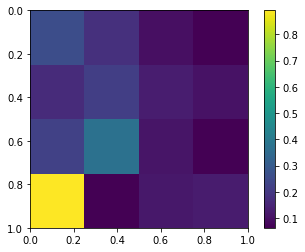

In [ ]:
extent = [0, 1, 1, 0]
plt.imshow(Z, origin='lower', extent=extent)
plt.colorbar()

### Task Inference

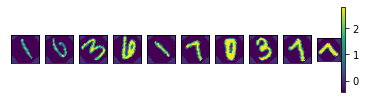

RuntimeError: stack expects a non-empty TensorList

In [ ]:
seed = 10
data, label = next(iter(loaders[0]))
data = temporal_data(data, 5, False).to(device)
num_examples = 10

c_data, target = get_continual_task(data, label, continual_task, 10, seed, n_tasks=n_tasks+5)
plot_grid(c_data[0, :10, ...].cpu())

pred, confidence, logits, entropy, g = oneshot_task_inference(community, c_data, num_examples=num_examples, shots=1, e_function=0)
pred = int(pred)

metric = lambda : (-g.squeeze()).cpu().data.numpy()

plt.figure(1)
plt.plot(range(n_tasks), metric())
plt.plot(seed, metric()[seed], 'ro', label='seed')
plt.plot(pred, metric()[pred], 'go', label='pred')
plt.xticks(range(n_tasks))
plt.show()

pred, confidence, logits, entropy, g = oneshot_task_inference(community, c_data, num_examples=num_examples, shots=1, e_function=1)
pred = int(pred)

plt.figure(2)
plt.plot(range(n_tasks), metric())
plt.plot(seed, metric()[seed], 'ro', label='seed')
plt.plot(pred, metric()[pred], 'go', label='pred')
plt.xticks(range(n_tasks))
plt.show()

get_logits = lambda s : community(c_data[:, :num_examples], str(s))[0][-1].sum(0)
cross_entropies = [F.cross_entropy(get_logits(s), target[:num_examples]).cpu().data.item() for s in range(32)]

plt.figure(3)
plt.plot(cross_entropies)
plt.plot(seed, cross_entropies[seed], 'ro', label='seed')
plt.plot(pred, cross_entropies[pred], 'go', label='pred')
plt.xticks(range(n_tasks))
plt.show()

entropies = [get_entropy(get_logits(s), 10).cpu().data.item() for s in range(32)]
plt.figure(4)
plt.plot(entropies)
plt.plot(seed, entropies[seed], 'ro', label='seed')
plt.plot(pred, entropies[pred], 'go', label='pred')
plt.xticks(range(n_tasks))
plt.show()


In [ ]:
seed = 1
data, label = next(iter(loaders[0]))
data = new_data(data, 5, False).to(device)
num_examples = -1

c_data, target = get_continual_task(data, label, continual_task, 10, seed, n_tasks=n_tasks+5)

pred, grads = binary_task_inference(community, c_data, num_examples=num_examples, e_function=1)
pred = int(pred)
for i, g in enumerate(grads) : 
    plt.figure(i)
    plt.plot(g)
    plt.plot(seed, g[seed], 'ro', label='seed')
    plt.plot(pred, g[pred], 'go', label='pred')
    #plt.xticks(range(n_tasks))
    plt.show()

In [ ]:
from tqdm.notebook import tqdm

def test_os_task_inference(community, shots=1, num_examples=5, n_tests=100) : 
    total, correct = 0, 0
    for _ in tqdm(range(n_tests)) : 
        data, label = next(iter(loaders[0]))
        data = new_data(data, 5, False).to(device)
        for seed in community.task_ids : 
            c_data, target = get_continual_task(data, label, continual_task, 10, seed, n_tasks=n_tasks+5)
            #community(data, str(task))
            total +=1
            correct += oneshot_task_inference(community, c_data, shots, num_examples, e_function=0)[0] == seed

    return correct/n_tests, correct/total

def test_bin_task_inference(community, num_examples=5, n_tests=100) : 
    total, correct = 0, 0
    for _ in tqdm(range(n_tests)) : 
        data, label = next(iter(loaders[0]))
        data = new_data(data, 5, False).to(device)
        for seed in community.task_ids : 
            c_data, target = get_continual_task(data, label, continual_task, 10, seed, n_tasks=n_tasks+5)
            #community(data, str(task))
            total +=1
            correct += binary_task_inference(community, c_data, num_examples)[0] == seed

    return correct/n_tests, correct/total

#print(test_bin_task_inference(community, n_tests=3, num_examples=1))
print(test_os_task_inference(community, n_tests=50, num_examples=1))


### Mask Plots

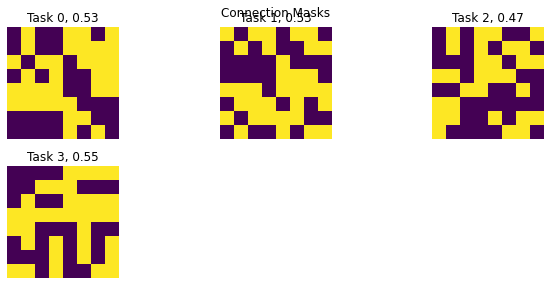

In [ ]:
tasks = lambda model : list(model.connection_scores.keys())
n_samples = 0

def plot_connections_masks(community, n_samples=1) : 
    n_tasks = len(community.task_ids)
    n_1 = int(np.sqrt(n_tasks)) #+ 1
    n_2 = n_tasks//n_1 +1
    
    fig = plt.figure(figsize=(n_2*3, n_1*2))
    subnets_total = []
    for task_id in tasks(community) : 
        task = int(task_id)
        ax = fig.add_subplot(n_1 , n_2, task+1)# , sharex=True, sharey=True)
        subnet, _ = community.get_connection_mask(task_id, n_samples=n_samples)
        
        if community.temporal_masks : 
            subnet = subnet.reshape(-1, subnet.shape[-1])
            
        elif len(subnet.shape)>2 : subnet = subnet.mean(0)

        subnets_total.append(subnet)
        
        ax.imshow(subnet.cpu().data.numpy())
        ax.set_title(f'Task {task}, {np.around(subnet.mean().cpu().item(), 2)}')
        ax.set_axis_off()
    fig.tight_layout()
    fig.suptitle('Connection Masks')
    fig.show()

def plot_output_masks(community, n_samples=1) : 
    n_tasks = len(community.task_ids)
    n_1 = int(np.sqrt(n_tasks)) #+ 1
    n_2 = n_tasks//n_1 #+ 1
    
    if n_1*n_2 != n_tasks : 
        n_2 += 1

    ims = {}
    fig = plt.figure(figsize=(n_2*3.5, n_1*2))
    subnets_total = []
    for task_id in tasks(community) : 
        task = int(task_id)
        
        #subnet = community.get_output_mask(task_id, n_samples=n_samples)[0].unsqueeze(0)
        subnet = (community.get_connection_mask(task_id, n_samples)[0]).diag().unsqueeze(0)
        
        if len(subnet.shape)>2 : subnet = subnet.mean(1)
        subnets_total.append(subnet)
        try : 
            first_mask = first_masks['Output'][task_id].unsqueeze(0)
            #subnet = torch.cat([first_mask, torch.zeros_like(first_mask), subnet])
        except NameError : 
            pass
        
        ax = fig.add_subplot(n_1 , n_2, task+1)# , sharex=True, sharey=True)
        im = ax.imshow(subnet.cpu().data.numpy(), cmap='viridis', vmin=0, vmax=1)
        try : 
            ax.set_title(f'Task {task}, Agent : {np.around(subnet.argmax().cpu().item(), 2)}, Acc : {acc_per_seed[task_id]:.2f}')
        except NameError : 
            ax.set_title(f'Task {task}, Agent : {np.around(subnet.argmax().cpu().item(), 2)}')
        ax.set_axis_off()
        
    used_agents = np.sort([s.argmax().cpu().item() for s in subnets_total])
    unique = len(torch.unique_consecutive(torch.stack(subnets_total)[:, 0, :], dim=0))/len(subnets_total)*100
    fig.suptitle(f'Output Masks, Unique = {unique}%')
    fig.tight_layout()
    cbar = fig.colorbar(im, ax=fig.axes, shrink=0.95)
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels(['OFF', 'ON'])
    
    fig.show()
    return subnets_total
    
subnets_total = plot_connections_masks(community, n_samples)
#subnets_total = plot_output_masks(community, 1)
#subnets_total = plot_output_masks(community, n_samples)
 

In [ ]:
conn_list = [community.get_connection_mask(t, 0)[0].cpu().data.view(1, -1, 8) for t in community.task_ids]
connected_from = lambda mask : mask.diag()
out_list = [connected_from(community.get_connection_mask(t, 0)[0]).unsqueeze(0).unsqueeze(0).cpu().data for t in community.task_ids]
rows = 5
grid = lambda c_list : [c_list[i::rows] for i in range(rows)]
plot_grid(grid(conn_list), figsize=(30, 10))
plot_grid(grid(out_list), figsize=(30, 10))

In [ ]:
deciding_agents = {}
n_tests = 10
for _ in tqdm(range(n_tests)) : 
    for seed in community.task_ids : 
        data, label = next(iter(loaders[0]))
        data = new_data(data, 5, False).to(device)
        c_data, target = get_continual_task(data, label, continual_task, 10, seed, n_tasks=n_tasks+5)
        outputs, _ = community(data, str(task))
        _, deciding_ags = get_decision(outputs, *decision_params)
        try : 
            deciding_agents[seed] += deciding_ags.float().mean()/n_tests
        except KeyError : 
            deciding_agents[seed] = deciding_ags.float().mean()/n_tests
        

In [ ]:
datas = []
labels = []

data, label = next(iter(loaders[0]))
data = new_data(data, 5, False).to(device)
label = label.to(device)

for task in range(n_tasks) : 
    c_data, c_target = get_continual_task(data, label, continual_task, 10, task, n_tasks)
    #print(c_target)
    c_data = c_data[-1][0].cpu()
    if len(c_data)>1 : 
        c_data = c_data.view(1, -1, c_data.shape[-1])
        
    datas.append(c_data)
    labels.append(c_target[0].cpu().data.item())
    
plot_grid(datas, labels=labels)

In [ ]:
data.shape

## Global Workspace

In [ ]:
data, target = next(iter(double_train_loader))
data = new_data(data, 2, False).to(device)

n_hid = 50
n_out = 10

community = GlobalWorkspaceCommunity(data[0][0].shape, Nhid=[2, 4], kernel_size=[7, 5], num_conv_layers=2,
                                     n_hid=n_hid, n_out=n_out, p_connect=1, pool_size = [2],
                                     decouple=False, distance_based_sparsity=True, cell_type=nn.GRU,
                                     use_deciding_agent=False, use_sparse_readout=True, use_attention=True).to(device)
#community.nb_connection

In [ ]:
community

In [ ]:
output, (states, scores) = community(data)

In [ ]:
output.shape

In [ ]:
params = lr, gamma = 1e-4, 0.9
params_dict = {'lr' : lr, 'gamma' : gamma}

deepR_params = l1, gdnoise, lr, gamma, cooling = 1e-5, 1e-3, 1e-3, 0.95, 0.95
deepR_params_dict = {'l1' : l1, 'gdnoise' : gdnoise, 'lr' : lr, 'gamma' : gamma, 'cooling' : cooling}

optimizers, schedulers = init_optimizers(community, params_dict, deepR_params_dict)

In [ ]:
n_epochs = 20
decision_params = ('last', 'max')

train_out = train_community(community, device, double_train_loader, double_test_loader, optimizers, 
                            schedulers=schedulers, n_epochs=n_epochs, global_rewire=True, 
                            task='parity_digits', decision_params=decision_params, data_mode='fixed',
                            deepR_params_dict=deepR_params_dict, trials = (True, True), train_connections=True)
                            
(train_losses, train_accs), (test_losses, test_accs), deciding_agents, nb_reconnect, nb_connections, best_state = train_out

In [ ]:
from torch.profiler import profile, record_function, ProfilerActivity
with profile(activities=[
    ProfilerActivity.CPU, ProfilerActivity.CUDA]) as prof:
    
    train_out = train_community(community, device, sub_train_loader, sub_test_loader, optimizers, 
                            schedulers=schedulers, n_epochs=n_epochs, global_rewire=True, 
                            task='parity_digits_100', decision_params=decision_params, data_mode='fixed',
                            deepR_params_dict=deepR_params_dict, trials = (True, True), train_connections=True)

print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

In [ ]:
plt.plot(test_accs)

In [ ]:
make_dot(output[0], dict(community.named_parameters())).render('graphs/GlobalWorkspace')

## Profiling

In [ ]:
gpu_profile_path = '/home/gb21/Code/SNNs/packages/gpu_memory_profiling/'
sys.path.append(gpu_profile_path)
from gpu_profile import gpu_profile

In [ ]:
os.environ['CUDA_VISIBLE_DEVICES']='1'
os.environ['GPU_DEBUG']='0'

sys.settrace(gpu_profile)

params = lr, gamma = 1e-6, 0.99
params_dict = {'lr' : lr, 'gamma' : gamma}

deepR_params = l1, gdnoise, lr, gamma, cooling = 1e-5, 1e-3, 5e-4, 0.99, 0.99
deepR_params_dict = {'l1' : l1, 'gdnoise' : gdnoise, 'lr' : lr, 'gamma' : gamma, 'cooling' : cooling}

optimizers, schedulers = init_optimizers(community, params_dict, deepR_params_dict)
                                         
n_epochs = 100
decision_params = ('last', 'max') 

train_out = train_community(community, device, train_loader, test_loader, optimizers, 
                            schedulers=schedulers, n_epochs=n_epochs, global_rewire=False, n_perm=200,
                            task='0', decision_params=decision_params, data_mode='fixed', check_gradients=False,
                            params_dict = params_dict, deepR_params_dict=deepR_params_dict,
                            trials = (True, True), train_connections=True)
                            
(train_losses, train_accs), (test_losses, test_accs), deciding_agents, nb_reconnect, nb_connections, best_state = train_out                                         